# Figure 10 Linear Fits to $\Delta\!$ MLat

In this notebook we show how we perform the linear fits to $\Delta\!$ MLat for the mean IMF By and a sine fit for the Clock Angle.
This notebook produces Figure 10 in the related paper.

## Imports
First we import the functions we need

In [1]:
#%% Imports
import pandas as pd
import numpy as np
from scipy.stats import linregress, iqr
from scipy import optimize
import matplotlib.pyplot as plt
from scipy.stats import t
from Subplot_alignment_tools import subplot_align
tinv = lambda p, df: abs(t.ppf(p/2, df))
import itertools

# Loading Dataset
Loading Onset file and created $\Delta\!$ MLT column

In [2]:
Onsets= pd.read_csv('./Mediated_Onsets.csv', parse_dates=['Date_NH'])
Onsets= Onsets[Onsets.flag==1][['Date_NH', 'Frey_MLAT', 'MLAT_SH']]
Onsets['DMLAT']=Onsets['MLAT_SH']-Onsets['Frey_MLAT']


## Rounding Time
Rounding the NH image time to the nearest minute

In [3]:
diff= Onsets.Date_NH-Onsets.Date_NH.values.astype('datetime64[m]')
delta= np.zeros(diff.shape).astype('timedelta64[m]')
delta[diff.values>=np.timedelta64(30, 's')]=np.timedelta64(1, 'm')
Onsets['Date_UTC']=Onsets.Date_NH.values.astype('datetime64[m]').astype('datetime64[ns]')+delta

## Loading Omni
Load the omni data and set values to 'NaN' when the required number of data points in the window is not satisfied.

In [4]:
omni= pd.read_hdf('./omni_data.hdf5', key='omni_window_2h_20')
omni.loc[omni['points']<120*.9, ['BX_GSE_Mean','BY_GSM_Mean',
                                 'BZ_GSM_Mean','Clock_GSM_SEM',
                                 'Clock_GSM_Mean']]=np.nan
omni['Date_UTC']= omni.index.values
omni.index= list(range(len(omni)))

## Merging Omni and Onset dataframes using the time column

In [5]:
Onsets= Onsets.merge(omni, on='Date_UTC')


## Handling Outliers
We use 1.5 times the interquartile range over and under the upper and lower quartiles to define outliers and create a boolean that is False for outliers

In [6]:
upper_lim= Onsets.DMLAT<np.quantile(Onsets.DMLAT, .75)+iqr(Onsets.DMLAT)*1.5
lower_lim= Onsets.DMLAT>np.quantile(Onsets.DMLAT, .25)-iqr(Onsets.DMLAT)*1.5
rm_out= upper_lim&lower_lim

## Linear Fit to Dipole Tilt

In [7]:
x, y= Onsets[rm_out].Dipole_Tilt.values, Onsets[rm_out].DMLAT.values # We exclude outliers from the fit
ind= np.isfinite(x)&np.isfinite(y) # We also remove 'NaN's which we removes rows where the averaged OMNI does not have enough data points in the averaging window
L_mean= linregress(x[ind], y[ind])
ts_lin = tinv(0.1, len(x)-2) # Define confidence level (e.g., 90%)

## Plotting
First we set the defaults for plotting

In [8]:
colors= ['#003f5c', '#bc5090', '#ffa600']
s=10
xlim= (-40, 40)
ylim= (-9, 9)


### Creating Figure

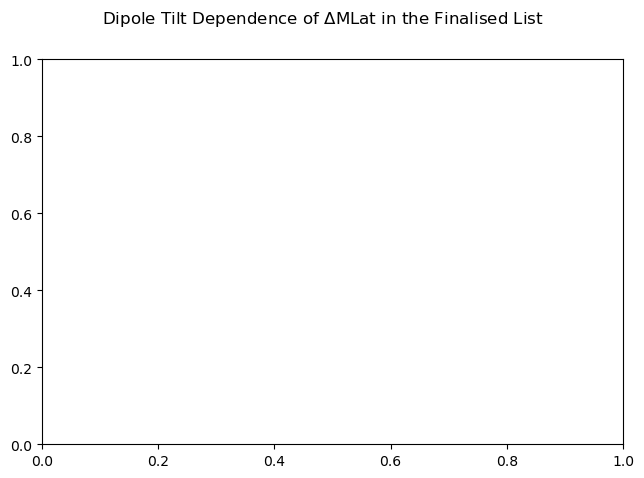

In [9]:
fig= plt.figure('Mean_Original', figsize=(7.5, 5))
fig.suptitle('Dipole Tilt Dependence of $\Delta$MLat in the Finalised List')
ax= fig.add_subplot(111)

#### Scatter Data points

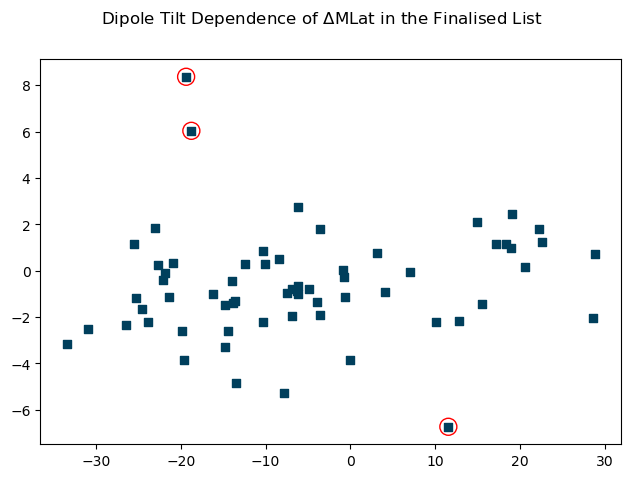

In [10]:
ax.scatter(Onsets[~rm_out].Dipole_Tilt, Onsets[~rm_out].DMLAT, marker= 'o', facecolors='none', edgecolors='r', label='Outliers', s=s*15, zorder=100)
ax.scatter(Onsets.Dipole_Tilt, Onsets.DMLAT, label='Onsets', marker='s', color=colors[0], s=s*3, zorder=101)
fig

#### Plotting Linear Fit

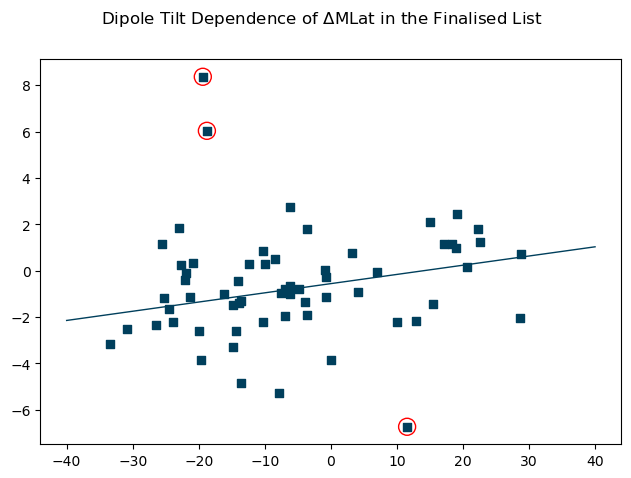

In [11]:
L= L_mean
ts= ts_lin
txt= f' {np.round(L.slope, 3)}'+r'$\psi$'+ f'  {np.round(L.intercept, 3):+}\n'+\
      ' '*12+r'$\pm$'+f'{np.round(ts*L.stderr, 3)}'+\
      ' '*2+r'$\pm$'+f'{np.round(ts*L.intercept_stderr, 3)}'
ax.plot(np.linspace(*xlim, 100), L.slope*np.linspace(*xlim, 100) +L.intercept, 
        linestyle='-', lw=1, label=r'$\Delta$MLat='+' '+ txt, color= colors[0], zorder=1000)
fig

#### Confidence Interval for By
We now calculate and plot the 90% confidence interval for the linear fit to By

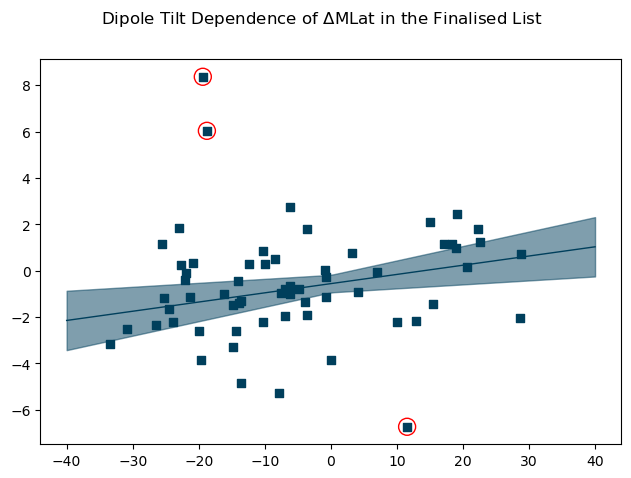

In [12]:
y1= (L.slope + ts*L.stderr)*np.linspace(*xlim, 100)\
      + (L.intercept + ts*L.intercept_stderr)
y2= (L.slope - ts*L.stderr)*np.linspace(*xlim, 100)\
      + (L.intercept - ts*L.intercept_stderr)

y3= (L.slope + ts*L.stderr)*np.linspace(*xlim, 100)\
      + (L.intercept - ts*L.intercept_stderr)
y4= (L.slope - ts*L.stderr)*np.linspace(*xlim, 100)\
      + (L.intercept + ts*L.intercept_stderr)
y= np.vstack([y1, y2, y3, y4])
ax.fill_between(np.linspace(*xlim, 100), np.min(y, axis=0), np.max(y, axis=0), color=colors[0], alpha=.5, zorder=110,
                label='90% Confidence\nInterval')
fig

#### Add zero lines and set x and y limits

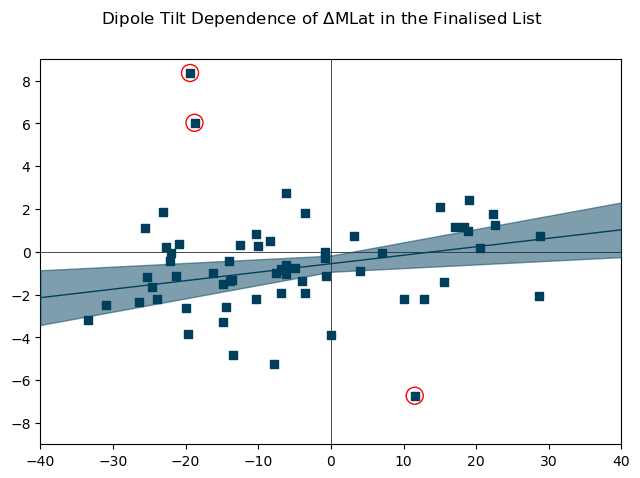

In [13]:
ax.axhline(0, color='black', lw=.5, zorder=-1)
ax.axvline(0, color='black', lw=.5, zorder=-1)

ax.set_xlim(*xlim)
ax.set_ylim(*ylim)
fig

### Creating Legends

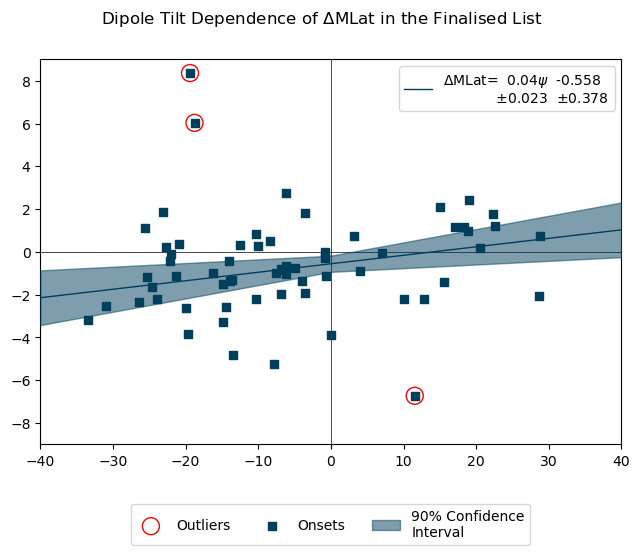

In [14]:
for ax_, loc in zip((ax, ), ('upper right', 'upper right')):
    h, l= ax_.get_legend_handles_labels()
    leg=ax_.legend(loc=loc, handles=[h[-2]], labels=[l[-2]])
    leg.set_zorder(10000)
leg1_ax= fig.add_subplot([.1, 0, .4, .1])
subplot_align(leg1_ax, ax, dim='x')
leg1_ax.axis('off')
h=[h[0], h[1], h[-1]]
l=[l[0], l[1], l[-1]]
leg1_ax.legend(loc='center', bbox_to_anchor=(.5, -.5), handles= h, labels= l, ncol=4)
fig

### Formatting axes

- Adding minor ticks
- Removing unneccessary axes lines
- moving clock angle ticks to right side

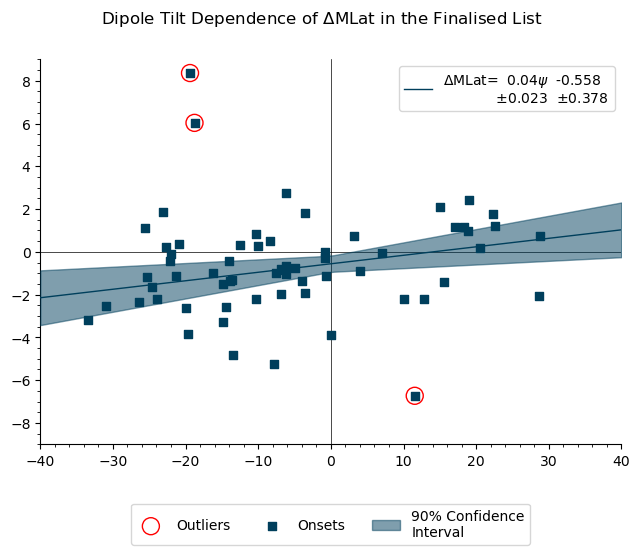

In [15]:
for ax_ in (ax, ):
    ax_.spines['top'].set_visible(False)
    ax_.minorticks_on()
ax.spines['right'].set_visible(False)
fig

### Addding Labels

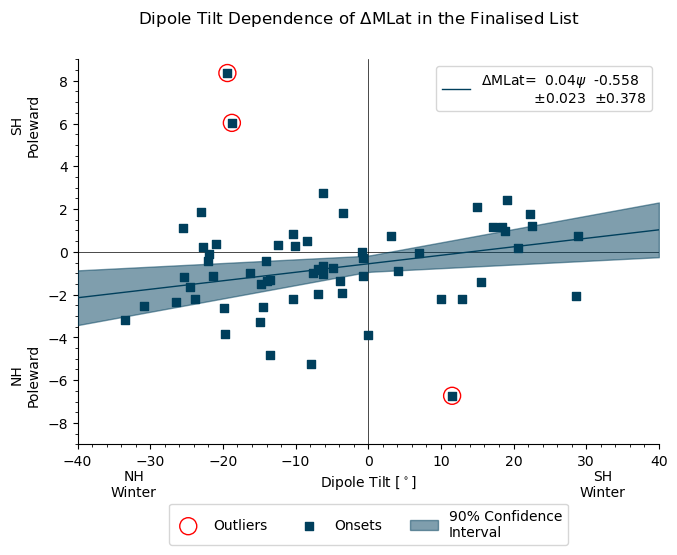

In [16]:
fig.text(.055, .25, 'NH\nPoleward', rotation=90, va='center', ha='center')
fig.text(.055, .75, 'SH\nPoleward', rotation=90, va='center', ha='center')

fig.text(.2, 0.03, 'NH\nWinter', rotation=0, va='center', ha='center')
fig.text(.825, 0.03, 'SH\nWinter', rotation=0, va='center', ha='center')

ax.set_xlabel(r'Dipole Tilt [$^\circ$]')
fig

## Save Fit

In [17]:
Dip= {'m':L_mean.slope, 'c':L_mean.intercept}
fits={'Dip':Dip}
file= open('./fitting_params_MLAT.txt', mode='w')

file.write(str(fits))
file.close()